In [1]:
import cv2
import sys
import numpy as np
import os 
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
from focalnet import load_focalnet, IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD, imagenet1k, imagenet22k

In [3]:
#mixed_precision.set_global_policy('mixed_float16')

In [4]:
def Normalizer(image):
    max_, min_ = image.max(), image.min()
    image = (image-min_)/(max_ - min_)
    return image

def merge_heatmap(images):
    mins, maxs = [], []
    new = []
    for image in images:
        if len(image.shape) == 4:
            image = image.squeeze(0)
        min_, max_ = image.max(), image.min()
        image = (image-min_)/(max_ - min_)
        new.append(image)
        mins.append(min_)
        maxs.append(max_)
    new = np.stack(new).mean(0)
    # rescale
    new = (new * (maxs[0] - mins[0])) + mins[0]
    return new

def Upsampler(heatmap, shape):
    heatmap = np.linalg.norm(heatmap.astype(np.float32), ord=1, axis=-1)
    upsample = cv2.resize(heatmap, shape)
    upsample = Normalizer(upsample)
    return np.expand_dims(upsample, axis=-1)

def center_crop(image, output_shape):
    # Get the input shape
    h, w, c = image.shape

    # Get the output shape
    h_desired, w_desired = output_shape

    # Check if the output shape is valid
    if h_desired > h or w_desired > w  :
        raise ValueError("Output shape must be smaller than or equal to input shape and have the same number of channels.")

    # Compute the crop coordinates
    h_start = (h - h_desired) // 2
    h_end = h_start + h_desired
    w_start = (w - w_desired) // 2
    w_end = w_start + w_desired

    # Crop the image and return it
    return image[h_start:h_end, w_start:w_end, :]

In [5]:
def preprocess_image(image ):
    #image = cv2.resize(image, input_shape)
    image = image/255.0
    image = (image - IMAGENET_DEFAULT_MEAN)/IMAGENET_DEFAULT_STD
    
    return np.expand_dims(image, axis=0)

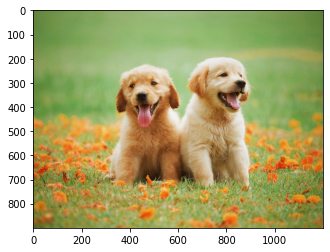

In [6]:
image = cv2.cvtColor(cv2.imread("../tests/dog.jpg"), cv2.COLOR_BGR2RGB)
image_crop = center_crop(image, (768, 768))

plt.imshow(image)

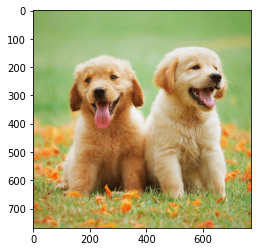

In [7]:
plt.imshow(image_crop)

In [8]:
output_shape = (224, 224)
image_resized = cv2.resize(image_crop, output_shape)
inputs = preprocess_image(image_crop)

In [19]:
model = load_focalnet(model_name='focalnet_tiny_srf', pretrained=True, return_model=False, act_head="softmax"   )

checkpoint focalnet_tiny_srf.h5 downloaded in c:\users\shiro\anaconda3\envs\tf2\lib\site-packages\focalnet\tmp


In [10]:
model.set_return_modulator(True)

In [11]:
output, modulators = model.predict(inputs)

1/1 [==============================] - 7s 7s/step


In [12]:
modulators[-1].shape

(1, 24, 24, 768)

In [13]:
print(output[0, np.argmax(output)])
print(imagenet22k[np.argmax(output)])

0.8313571
golden_retriever


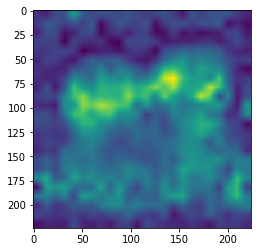

In [14]:
heatmap = Upsampler(modulators[-1].squeeze(0), output_shape) #(1200, 900))
plt.imshow(heatmap)

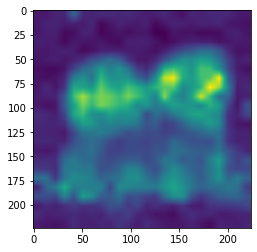

In [15]:
heatmap = Upsampler(merge_heatmap(modulators), output_shape) #(1200, 900))
plt.imshow(heatmap)

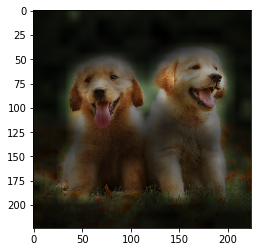

In [16]:
plt.imshow((heatmap*image_resized).astype(np.int32))

In [17]:
from focalnet import download_weights

In [18]:
download_weights.clean_checkpoint()